### Parte 2
Leitura dos arquivos LHE com a biblioteca pylhe

Monalisa Hansen

In [89]:
!pip install pylhe

In [90]:
!pip install particle

In [91]:
import pylhe
import itertools
import pandas as pd
from particle import Particle, PDGID
import numpy as np
import matplotlib.pyplot as plt
from itertools import combinations
from matplotlib.colors import LogNorm
import gzip

In [92]:
lhe_fundo_path = 'fundo.lhe.gz'
lhe_sinal_path = 'sinal.lhe.gz'

In [93]:
## [3] Exploração do Conteúdo

### Objetivo 1 - Construir histogramas para as partículas de estado final (exceto neutrinos):
def cinematic_variables(p, eps=1e-12):
  """Calcula as variáveis cinemáticas (pT, eta e phi) para uma partícula."""

  # calcular momento transversal pt
  pt = np.sqrt(p.px**2 + p.py**2)

  # calcular o ângulo azimutal phi
  phi = np.arctan2(p.py, p.px)

  # calcular o módulo do momento total
  p_mag = np.sqrt(p.px**2 + p.py**2 + p.pz**2)

  if p_mag < eps:
    return np.nan
  if (p_mag - p.pz) <= eps or (p_mag + p.pz) <= eps: # evitar divisão por zero
    return np.nan
  eta = 0.5 * np.log((p_mag + p.pz) / (p_mag - p.pz))

  return pt, phi, eta


def process_events(file_name, pt_min, pt_max, phi_min, phi_max, eta_min, eta_max):
  """
  Lê o arquivo LHE e extrai listas de pT, eta e phi
  para partículas finais (status == 1), excluindo neutrinos
  """
  pts, phis, etas = [], [], []
  neutrinos_ids = [12, 14, 16]

  # contadores
  total_events = 0
  events_pt, events_phi, events_eta = 0, 0, 0

  # criar novamente o gerador para garantir a leitura do início
  events = pylhe.LHEFile.fromfile(file_name).events

  for event in events:
    total_events += 1

    # flag para saber se esse evento contribuiu para o gráfico
    valid_pt = False
    valid_phi = False
    valid_eta = False

    for p in event.particles:
      if p.status == 1 and abs(p.id) not in neutrinos_ids:
        pt, phi, eta = cinematic_variables(p, eps=1e-12)

        # aplicação dos limites
        pt_lim = (pt >= pt_min) and (pt <= pt_max)
        if pt_lim:
          pts.append(pt)
          valid_pt = True

        phi_lim = (phi >= phi_min) and (phi <= phi_max)
        if phi_lim:
          phis.append(phi)
          valid_phi = True

        eta_lim = (eta >= eta_min) and (eta <= eta_max)
        if eta_lim:
          etas.append(eta)
          valid_eta = True

    if valid_pt:
      events_pt += 1

    if valid_phi:
      events_phi += 1

    if valid_eta:
      events_eta += 1

  return pts, phis, etas

## [4] Filtros e Cortes Cinemáticos

### Objetivo 1 - Analisar se cortes cinemáticos simples ajudam a remover o fundo.
### Objetivo 2 - Se for útil, aplique o corte e reconstrua os histogramas com a nova seleção.

pt_sinal_cut, phi_sinal, eta_sinal_cut = process_events(lhe_sinal_path, 25, 100, -np.pi, np.pi, -2.5, 2.5)
pt_fundo_cut, phi_fundo, eta_fundo_cut = process_events(lhe_fundo_path, 25, 100, -np.pi, np.pi, -2.5, 2.5)

In [94]:
## [5] CONSERVAÇÃO DE ENERGIA
# Print na célula o valor da variável de Mandelstam "s" para cada 1+1000*i eventos,
# em que i=[0,9].
# Calcule "s" somente com partículas de status == 1 e sem neutrinos.

def calculate_mandelstam_and_invmass(obj_input):
  """
Calcula s e massa invariante.
    Aceita como entrada:
    1. Um evento completo (pylhe.LHEEvent) -> filtra status 1 e neutrinos.
    2. Uma lista/tupla de partículas (ex: um par) -> calcula sobre elas.
  """

  # verificação -> eventos ou lista com combinações de partículas (pares, por ex.)
  if hasattr(obj_input, 'particles'):
    # é um evento completo do pylhe
    particles_list = obj_input.particles
  else:
    # já é uma lista ou tupla de partículas
    particles_list = obj_input

  # inicializando as variáveis de energia e momento
  E_tot = 0
  px_tot = 0
  py_tot = 0
  pz_tot = 0

  neutrinos_ids = [12, 14, 16]

  for p in particles_list:
    if p.status == 1 and abs(p.id) not in neutrinos_ids:
      E_tot += p.e
      px_tot += p.px
      py_tot += p.py
      pz_tot += p.pz

  # cálculo do momento total
  P_tot = px_tot**2 + py_tot**2 + pz_tot**2

  # cálculo de s
  s = E_tot**2 - P_tot

  # garante que s não é ligeiramente negativo devido a erros de ponto flutuane
  # embora teoricamente s > 0 para partículas massivas.
  return max(0, s), np.sqrt(max(0, s))

def analyze_mandelstam(file_path, file_name):
  """
  Calcula e imprime a variável de Mandelstam (s) para cada 1+1000*i eventos,
  onde i=[0,9].
  """
  print(f'\nVariável de Mandelstam para o arquivo {file_name}.')

  try:
    events_list = list(pylhe.LHEFile.fromfile(file_path).events)
    total_events = len(events_list)

  except Exception as e:
    print(f'Erro ao ler o arquivo {file_name}: {e}')
    return

  # iterar sobre os índices i, com i=[0,9]
  for i in range(10):
    target_index = 1000 * i

    # pular eventos anteriores ao alvo
    # (target_index + 1) é o número de eventos para pular, incluindo o evento de índice 0
    event_number = target_index + 1

    if target_index < total_events:
      event = events_list[target_index]
      s, mass_inv = calculate_mandelstam_and_invmass(event)

      print(f'Evento {target_index + 1}: s = {s:.3f} GeV^2')

    else:
      print(f'Fim do arquivo alcançado (Total: {total_events}. Evento {event_number} não encontrado.)')
      break

analyze_mandelstam(lhe_fundo_path, 'FUNDO')
analyze_mandelstam(lhe_sinal_path, 'SINAL')


Variável de Mandelstam para o arquivo FUNDO.
Evento 1: s = 19519.168 GeV^2
Evento 1001: s = 9265.376 GeV^2
Evento 2001: s = 7912.778 GeV^2
Evento 3001: s = 65539.238 GeV^2
Evento 4001: s = 5513.966 GeV^2
Evento 5001: s = 9086.714 GeV^2
Evento 6001: s = 38142.415 GeV^2
Evento 7001: s = 22238.024 GeV^2
Evento 8001: s = 24148.433 GeV^2
Evento 9001: s = 10311.748 GeV^2

Variável de Mandelstam para o arquivo SINAL.
Evento 1: s = 85093.014 GeV^2
Evento 1001: s = 102147.465 GeV^2
Evento 2001: s = 187047.805 GeV^2
Evento 3001: s = 50165.559 GeV^2
Evento 4001: s = 39000.715 GeV^2
Evento 5001: s = 42909.796 GeV^2
Evento 6001: s = 76378.835 GeV^2
Evento 7001: s = 69955.639 GeV^2
Evento 8001: s = 37906.299 GeV^2
Evento 9001: s = 65524.694 GeV^2


Processando Fundo...
Processando Sinal...

Contagens de pares encontrados (sinal):
  ee: 10000
  mumu: 10000
  gamgam (Fótons): 0
  jj (Jatos): 0


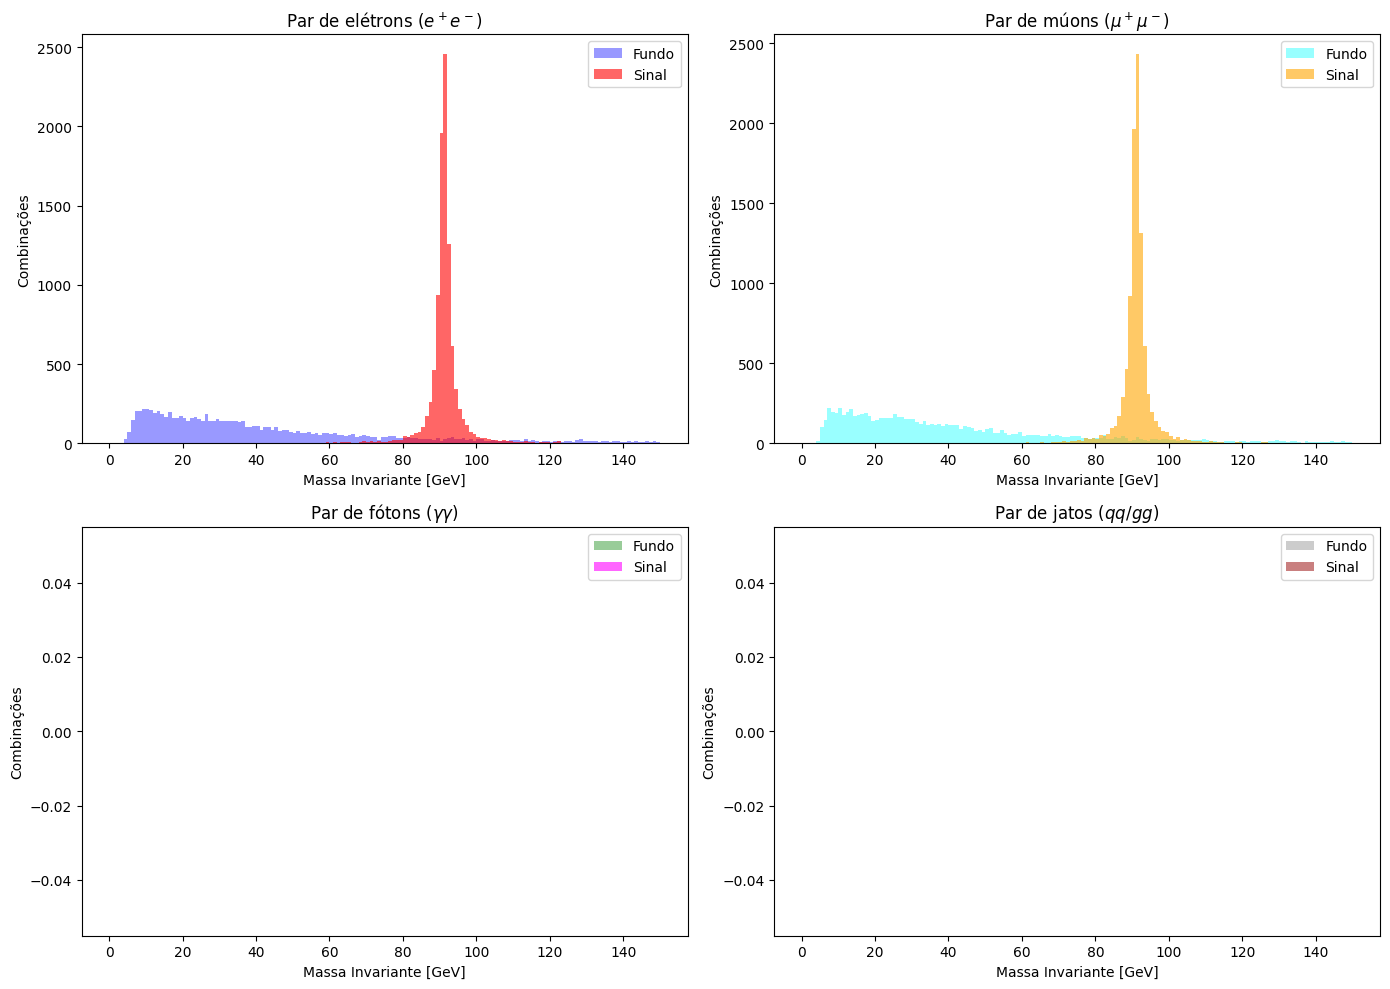

In [95]:
# [6] RECONSTRUÇÃO DE VARIÁVEIS
# Construa um ou mais histogramas de Massa Invariante entre pares de partículas:
# 1. Forme pares de partículas presentes no evento
# (ex: dois múons, dois fótons, dois jatos, etc) - um histograma para cada par.

# IDs Padrão do PDG
ID_ELETRON = 11
ID_MUON = 13
ID_FOTON = 22
IDS_JATOS = [1, 2, 3, 4, 5, 6, 21] # Quarks (1-6) e Glúon (21)

def inv_mass_pair_flavors(file_path):
    """
    Calcula massa invariante para pares de:
    - Elétrons (ee)
    - Múons (mumu)
    - Fótons (gamgam)
    - Jatos (jj - quarks/glúons)
    """
    # dicionário para guardar as listas de resultados
    masses = {
        'ee': [],
        'mumu': [],
        'gamgam': [],
        'jj': []
    }

    try:
        events = pylhe.LHEFile.fromfile(file_path).events
    except Exception as e:
        print(f"Erro ao ler {file_path}: {e}")
        return masses

    for event in events:
        # listas temporárias para o evento ATUAL
        l_ele = []
        l_mu = []
        l_gam = []
        l_jet = []

        # classificação das partículas do evento
        for p in event.particles:
            if p.status == 1:
                aid = abs(p.id)

                if aid == ID_ELETRON:
                    l_ele.append(p)
                elif aid == ID_MUON:
                    l_mu.append(p)
                elif aid == ID_FOTON:
                    l_gam.append(p)
                elif aid in IDS_JATOS:
                    l_jet.append(p)

        # formação de pares e cálculo
        def process_pairs(particles_list, key_dic):
            if len(particles_list) >= 2:
                for pair in combinations(particles_list, 2):
                    _, m_inv = calculate_mandelstam_and_invmass(pair)
                    masses[key_dic].append(m_inv)

        # Processar cada categoria
        process_pairs(l_ele, 'ee')
        process_pairs(l_mu, 'mumu')
        process_pairs(l_gam, 'gamgam')
        process_pairs(l_jet, 'jj')

    return masses

# print dos histogramas
print("Processando Fundo...")
dados_fundo = inv_mass_pair_flavors(lhe_fundo_path)

print("Processando Sinal...")
dados_sinal = inv_mass_pair_flavors(lhe_sinal_path)

# verificação rápida se encontramos algo novo
print(f"\nContagens de pares encontrados (sinal):")
print(f"  ee: {len(dados_sinal['ee'])}")
print(f"  mumu: {len(dados_sinal['mumu'])}")
print(f"  gamgam (Fótons): {len(dados_sinal['gamgam'])}")
print(f"  jj (Jatos): {len(dados_sinal['jj'])}")

fig, ax = plt.subplots(2, 2, figsize=(14, 10))
bins = 150
range_plot = (0, 150) # foco na região do Z e baixas energias

# função auxiliar para plotar cada sub-gráfico
def plot_channel(ax_obj, chave, titulo, cor_fundo, cor_sinal):
    ax_obj.hist(dados_fundo[chave], bins=bins, range=range_plot, alpha=0.4, label=f'Fundo', color=cor_fundo)
    ax_obj.hist(dados_sinal[chave], bins=bins, range=range_plot, alpha=0.6, label=f'Sinal', color=cor_sinal)
    ax_obj.set_title(titulo)
    ax_obj.set_xlabel('Massa Invariante [GeV]')
    ax_obj.set_ylabel('Combinações')
    ax_obj.legend()

# 1. Elétrons
plot_channel(ax[0,0], 'ee', r'Par de elétrons ($e^+e^-$)', 'blue', 'red')
# 2. Múons
plot_channel(ax[0,1], 'mumu', r'Par de múons ($\mu^+\mu^-$)', 'cyan', 'orange')
# 3. Fótons
plot_channel(ax[1,0], 'gamgam', r'Par de fótons ($\gamma\gamma$)', 'green', 'magenta')
# 4. Jatos
plot_channel(ax[1,1], 'jj', r'Par de jatos ($qq/gg$)', 'gray', 'brown')

plt.tight_layout()
plt.show()

### Análise dos histogramas de massa invariante por pares de partículas
Como foi visto nas etapas anteriores, o total de eventos é 10000

A contagem de pares do sinal feita acima mostrou que:

*   total de pares $ee$ (elétrons) = 10.000
*   total de Pares $\mu\mu$ (múons) = 10.000
*   total de Pares $\gamma\gamma$ (fótons) = 0
*   total de Pares $jj$ (jatos) = 0

Isso mostra que cada um dos 10.000 eventos tem exatamente a mesma configuração final: 2 elétrons e 2 múons ($2e 2\mu$).

PROVA:

Dentro de 1 Evento:
2 elétrons ($e^+, e^-$) e 2 múons ($\mu^+, \mu^-$)

Combinações de 2 elétrons possíveis num grupo de 2 $\rightarrow$
Apenas 1 par ($e^+$ com $e^-$).

Combinações de 2 múons possíveis num grupo de 2 $\rightarrow$
Apenas 1 par ($\mu^+$ com $\mu^-$).

No Arquivo Todo:

$10.000 \text{ eventos} \times 1 \text{ par } ee/\text{evento} = 10.000 \text{ pares } ee$.

$10.000 \text{ eventos} \times 1 \text{ par } \mu\mu/\text{evento} = 10.000 \text{ pares } \mu\mu$.

Isso significa que o arquivo de sinal não contém uma mistura aleatória de canais (como $4e$ ou $4\mu$). Ele é um arquivo exclusivo do canal misto:

$$H \to ZZ \to e^+ e^- \mu^+ \mu^-$$

Se houvesse eventos $4e$: a análise combinatória seria diferente. Num evento com 4 elétrons teriam $C_{4,2} = 6$ pares possíveis, o que resulta em 60.000 pares de elétrons. O mesmo racioncínio se aplica para eventos $4\mu$.

Como deu exatamente 10.000 (1 por evento), confirmamos o cenário $2e 2\mu$, com ausência total de atividade hadrônica (jatos) ou fotônica.

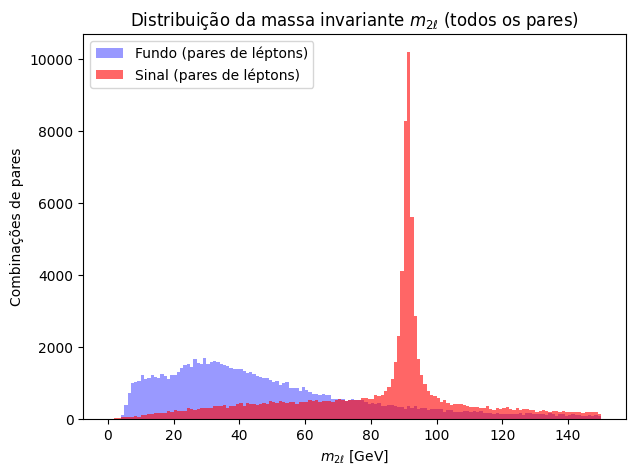

In [96]:
def eta_from_pxyz(px, py, pz, eps=1e-12):
    p_mag = np.sqrt(px**2 + py**2 + pz**2)

    # casos em que eta diverge (p paralelo ao feixe) ou dá problema numérico
    if p_mag < eps:
        return np.nan
    if (p_mag - pz) <= eps or (p_mag + pz) <= eps:
        return np.nan

    return 0.5 * np.log((p_mag + pz) / (p_mag - pz))

def inv_mass_total_and_eta(file_path):
  """
  Calcula a massa invariante para todos os pares possíveis de léptons
  em todos os eventos e o eta do sistema do par (somando os momentos)
  """
  masses_2l = []
  etas_2l = []
  neutrinos_ids = [12, 14, 16]

  try:
    events = pylhe.LHEFile.fromfile(file_path).events
  except Exception as e:
    print(f"Erro ao ler {file_path}: {e}")
    return np.array([]), np.array([])

  for event in events:
    valid_particles = []
    for p in event.particles:
      if p.status == 1 and abs(p.id) not in neutrinos_ids:
        valid_particles.append(p)

      if len(valid_particles) >= 2:
        for pair in combinations(valid_particles, 2):
          _, m_inv_pair = calculate_mandelstam_and_invmass(pair)

          px = pair[0].px + pair[1].px
          py = pair[0].py + pair[1].py
          pz = pair[0].pz + pair[1].pz
          eta_pair = eta_from_pxyz(px, py, pz)

          masses_2l.append(m_inv_pair)
          etas_2l.append(eta_pair)

  return np.array(masses_2l, dtype=float), np.array(etas_2l, dtype=float)

# gera massas + etas par-a-par
masses_2l_sinal, etas_2l_sinal = inv_mass_total_and_eta(lhe_sinal_path)
masses_2l_fundo, etas_2l_fundo = inv_mass_total_and_eta(lhe_fundo_path)

# [6] 2. Se o evento conter mais de duas partículas estáveis,
# construa o histograma de massa invariante de todas elas combinadas.
# histograma massa invariante de todos os pares de léptons
plt.figure(figsize=(7, 5))

bins = 150
range_m2l = (0, 150)

plt.hist(masses_2l_fundo, bins=bins, range=range_m2l, alpha=0.4, label='Fundo (pares de léptons)', color='blue', density=False)
plt.hist(masses_2l_sinal, bins=bins, range=range_m2l, alpha=0.6, label='Sinal (pares de léptons)', color='red', density=False)

plt.title(r'Distribuição da massa invariante $m_{2\ell}$ (todos os pares)')
plt.xlabel(r'$m_{2\ell}$ [GeV]')
plt.ylabel('Combinações de pares')
plt.legend()
plt.show()

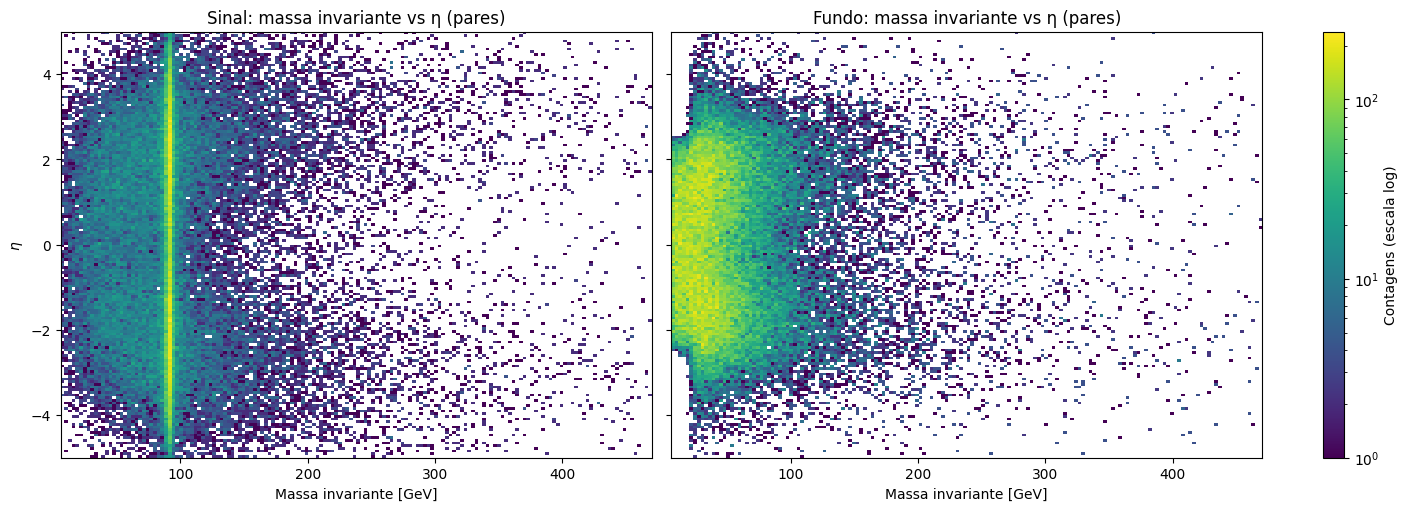

In [97]:
# [6] 3. Histogramas 2D (mapa de calor) de massa invariante versus \eta para sinal e fundo separadamente.
# limpa outliers/NaN e corta faixa física de eta para não “sumir” com tudo
ETA_MIN, ETA_MAX = -5, 5

def clean(m, e):
  """
  Aplica um filtro de range do eta massa inveriante e no eta.
  """
  mask = np.isfinite(m) & np.isfinite(e) & (e >= ETA_MIN) & (e <= ETA_MAX)
  return m[mask], e[mask]

mS, eS = clean(masses_2l_sinal, etas_2l_sinal)
mF, eF = clean(masses_2l_fundo, etas_2l_fundo)

m_min = min(np.percentile(mS, 0.5), np.percentile(mF, 0.5))
m_max = max(np.percentile(mS, 99.5), np.percentile(mF, 99.5))
MASS_RANGE = (m_min, m_max)

fig, ax = plt.subplots(1, 2, figsize=(14, 5), sharey=True, constrained_layout=True)

h1 = ax[0].hist2d(mS, eS, bins=(160, 160),
                  range=[MASS_RANGE, (ETA_MIN, ETA_MAX)],
                  norm=LogNorm())
ax[0].set_title("Sinal: massa invariante vs η (pares)")
ax[0].set_xlabel("Massa invariante [GeV]")
ax[0].set_ylabel(r"$\eta$")

h2 = ax[1].hist2d(mF, eF, bins=(160, 160),
                  range=[MASS_RANGE, (ETA_MIN, ETA_MAX)],
                  norm=LogNorm())
ax[1].set_title("Fundo: massa invariante vs η (pares)")
ax[1].set_xlabel("Massa invariante [GeV]")

cbar = fig.colorbar(h1[3], ax=ax.ravel().tolist())
cbar.set_label("Contagens (escala log)")

plt.show()

Embora cada evento contenha apenas um par $e^+e^-$ e um par $\mu^+\mu^-$, na construção dos histogramas de massa invariante e dos mapas de calor foram consideradas todas as combinações possíveis de pares de partículas finais. Em eventos do tipo $2e2\mu$, isso resulta em seis combinações por evento: dois pares de mesmo sabor [$e^+e^-$, $\mu^+\mu^-$] e quatro pares mistos [$e^+\mu^+$, $e^+\mu^-$, $e^-\mu^+$, $e^-\mu^-$]. Assim, o número total de entradas nos histogramas é seis vezes maior que o número de eventos.

A faixa estreita em massa no histograma do sinal indica que muitos pares têm praticamente a mesma massa invariante, independentemente de $\eta$ (invariante de Lorentz).



In [98]:
# [7] GRÁFICOS E VISUALIZAÇÃO

LUMI_PB = 10000.0  # 10/fb = 10000/pb

def _open_text(path):
    return gzip.open(path, "rt") if path.endswith(".gz") else open(path, "r")

def read_xsec_pb_from_lhe(file_path):
  """
  soma XSECUP (sessão de choque) de todos subprocessos no bloco <init>
  """
  with _open_text(file_path) as f:
    for line in f:
      if "<init>" in line:
        break
    init_line = f.readline().strip().split()
    nprup = int(init_line[9])
    xsecs = []
    for _ in range(nprup):
      vals = f.readline().split()
      xsecs.append(float(vals[0]))
  return float(np.sum(xsecs))

def weight_per_event(file_path, lumi_pb=LUMI_PB):
  """
  Calcula o fator de normalização a partir da seção de choque e da luminosidade.
  """
  sigma_pb = read_xsec_pb_from_lhe(file_path)
  n_evt = pylhe.LHEFile.count_events(file_path)
  w = sigma_pb * lumi_pb / n_evt
  return sigma_pb, n_evt, w

# pesos por evento
sigma_S, nS, wS_evt = weight_per_event(lhe_sinal_path, LUMI_PB)
sigma_F, nF, wF_evt = weight_per_event(lhe_fundo_path, LUMI_PB)

print("SINAL: sigma(pb) =", sigma_S, "| w_evt =", wS_evt, "| yield =", sigma_S*LUMI_PB)
print("FUNDO: sigma(pb) =", sigma_F, "| w_evt =", wF_evt, "| yield =", sigma_F*LUMI_PB)
print("Razão yields S/F =", (sigma_S*LUMI_PB)/(sigma_F*LUMI_PB))


SINAL: sigma(pb) = 0.02110132 | w_evt = 0.02110132 | yield = 211.0132
FUNDO: sigma(pb) = 0.00021642 | w_evt = 0.00021642000000000002 | yield = 2.1642
Razão yields S/F = 97.50170963866556


### Normalização
Os resultados de $\sigma$ e de $\omega$ printados na célula acima são iguais. Devido à utilização de $L = 1000/fb$, $L$ e $N$ se anulam, visto que:

*   $\omega = \frac{(\sigma * L)}{N}$
*   $\sigma$ é a seção de choque
*   $L$ é a luminosidade
*   $N$ é o número de eventos ($N = 1000$)

Logo, a razão de normalização é $\frac{\sigma_{sinal}}{\sigma_{fundo}}$.

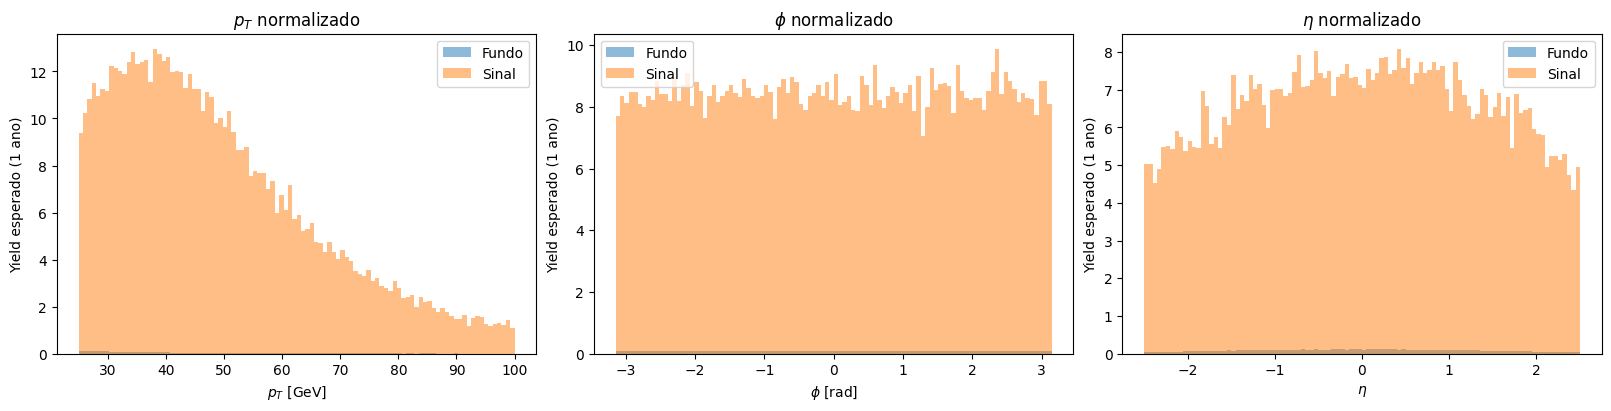

In [99]:
# [7] 1. Plotar os histogramas (pT, eta, phi da parte #1 e massa invariante da parte 2)
#normalizados pela seção de choque e luminosidade.

def plot_hist_norm(ax, x_fundo, x_sinal, wF, wS, bins, x_range, title, xlabel):
  """
  Plota os histogramas de pt, phi e eta normalizados.
  """
  ax.hist(x_fundo, bins=bins, range=x_range,
          weights=np.full(len(x_fundo), wF, dtype=float),
          alpha=0.5, label="Fundo")
  ax.hist(x_sinal, bins=bins, range=x_range,
          weights=np.full(len(x_sinal), wS, dtype=float),
          alpha=0.5, label="Sinal")
  ax.set_title(title)
  ax.set_xlabel(xlabel)
  ax.set_ylabel("Yield esperado (1 ano)")
  ax.legend()
bins = 100

fig, ax = plt.subplots(1, 3, figsize=(16, 4), constrained_layout=True)

# pT
plot_hist_norm(
    ax[0],
    pt_fundo_cut, pt_sinal_cut,
    wF_evt, wS_evt,
    bins=bins, x_range=(25, 100),
    title=r"$p_T$ normalizado",
    xlabel=r"$p_T$ [GeV]"
)

# phi
plot_hist_norm(
    ax[1],
    phi_fundo, phi_sinal,
    wF_evt, wS_evt,
    bins=bins, x_range=(-np.pi, np.pi),
    title=r"$\phi$ normalizado",
    xlabel=r"$\phi$ [rad]"
)

# eta
plot_hist_norm(
    ax[2],
    eta_fundo_cut, eta_sinal_cut,
    wF_evt, wS_evt,
    bins=bins, x_range=(-2.5, 2.5),
    title=r"$\eta$ normalizado",
    xlabel=r"$\eta$"
)

plt.show()

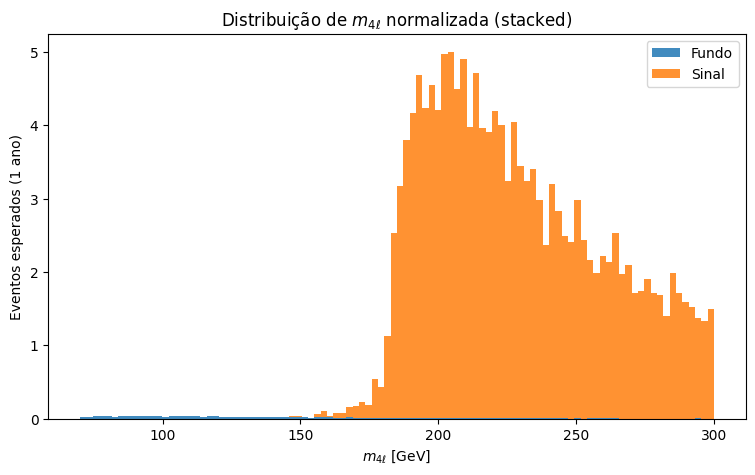

In [100]:
# [7] a. Distribuição de massa invariante normalizado e com os
#dois histogramas de sinal e fundo empilhados (stacked).

def inv_mass_4l_per_event(file_path):
    masses = []
    events = pylhe.LHEFile.fromfile(file_path).events
    for ev in events:
        _, m = calculate_mandelstam_and_invmass(ev)  # sua função do notebook
        masses.append(m)
    return np.array(masses, float)

# massas por evento
m4l_sinal = inv_mass_4l_per_event(lhe_sinal_path)
m4l_fundo = inv_mass_4l_per_event(lhe_fundo_path)

mass_range = (70, 300)
bins = 100

# stacked
plt.figure(figsize=(9, 5))

plt.hist(
    [m4l_fundo, m4l_sinal],
    bins=bins,
    range=mass_range,
    weights=[np.full(len(m4l_fundo), wF), np.full(len(m4l_sinal), wS)],
    stacked=True,
    label=["Fundo", "Sinal"],
    alpha=0.85
)

plt.xlabel(r"$m_{4\ell}$ [GeV]")
plt.ylabel("Eventos esperados (1 ano)")
plt.title(r"Distribuição de $m_{4\ell}$ normalizada (stacked)")

plt.legend()
plt.show()


### [8] COMENTÁRIOS
1. Faz sentido a proporção entre os histogramas normalizados com base na seção de choque presente nos arquivos LHE?

Sim, faz sentido. Dos arquivos LHE foram extraídos:

*   $\sigma_{sinal} = 0,02110132$ pb
*   $\sigma_{fundo} = 0.00021642$ pb

Logo,

$\frac{\sigma_{sinal}}{\sigma_{fundo}} = \frac{0,02110132}{0.00021642} \approx 97.5$

Então é esperado que o histograma do sinal domine e o fundo fique próximo de zero.


2. Você verifica alguma estrutura particular nas disitrubuições de massa invariante?

Sim, o histograma empilhado mostra que a distribuição cresce bastante acima de ~180–200 GeV. Isso é consistente com um efeito de limiar cinemático típico quando dois bósons massivos podem ser produzidos on-shell (por exemplo, quando $m_{4l}$ ultrapassa aproximadamente $2_{mz} \approx 182 GeV$).

Além disso, é nítida a presença de uma cauda longa em altas massas. Isso é típico de processos de espalhamento/produção contínua (não ressonante) ou de amostras geradas com grande faixa em energia invariável. Em particular, isso é diferente do que se esperaria de um sinal ressonante estreito em 125 GeV (Higgs leve), que geraria um pico localizado.

### Conclusão da comparação entre os métodos de análise
Os resultados das análises para o mesmo conjunto de arquivos LHE de sinal e de fundo foram muito semelhantes tanto com a biblioteca proprietária pylhe quanto tratanto os dados com DataFrames utilizando a biblioteca pandas.